In [1]:
pip install torch torchvision

In [2]:
!pip install d2l==0.17.2

In this section, we will introduce LeNet, among the first published CNNs to capture wide attention for its performance on computer vision tasks. 

##LeNet
At a high level, LeNet (LeNet-5) consists of two parts: (i) a convolutional encoder consisting of two convolutional layers; and (ii) a dense block consisting of three fully-connected layers.
We need only to instantiate a Sequential block and chain together the appropriate layers.

In [3]:
import tensorflow as tf
from d2l import tensorflow as d2l


def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid',
                               padding='same'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5,
                               activation='sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='sigmoid'),
        tf.keras.layers.Dense(84, activation='sigmoid'),
        tf.keras.layers.Dense(10)])

By passing a single-channel (black and white)  28×28  image through the network and printing the output shape at each layer, we can inspect the model to make sure that its operations line up with what we expect from figure below:

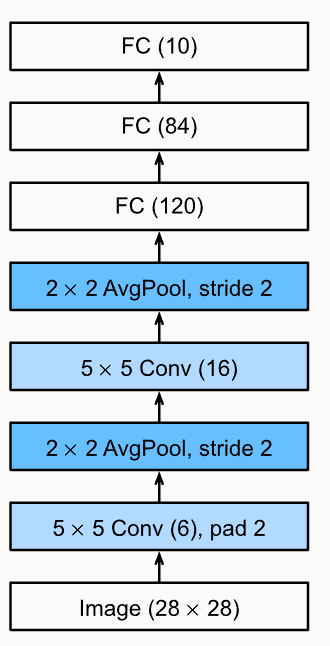

In [4]:
X = tf.random.uniform((1, 28, 28, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2D output shape: 	 (1, 28, 28, 6)
AveragePooling2D output shape: 	 (1, 14, 14, 6)
Conv2D output shape: 	 (1, 10, 10, 16)
AveragePooling2D output shape: 	 (1, 5, 5, 16)
Flatten output shape: 	 (1, 400)
Dense output shape: 	 (1, 120)
Dense output shape: 	 (1, 84)
Dense output shape: 	 (1, 10)


##Training

Now that we have implemented the model, let us run an experiment to see how LeNet fares on Fashion-MNIST.

In [5]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

While CNNs have fewer parameters, they can still be more expensive to compute than similarly deep MLPs because each parameter participates in many more multiplications. If you have access to a GPU, this might be a good time to put it into action to speed up training.

In [6]:
class TrainCallback(tf.keras.callbacks.Callback):  
    """A callback to visiualize the training progress."""
    def __init__(self, net, train_iter, test_iter, num_epochs, device_name):
        self.timer = d2l.Timer()
        self.animator = d2l.Animator(
            xlabel='epoch', xlim=[1, num_epochs], legend=[
                'train loss', 'train acc', 'test acc'])
        self.net = net
        self.train_iter = train_iter
        self.test_iter = test_iter
        self.num_epochs = num_epochs
        self.device_name = device_name
    def on_epoch_begin(self, epoch, logs=None):
        self.timer.start()
    def on_epoch_end(self, epoch, logs):
        self.timer.stop()
        test_acc = self.net.evaluate(
            self.test_iter, verbose=0, return_dict=True)['accuracy']
        metrics = (logs['loss'], logs['accuracy'], test_acc)
        self.animator.add(epoch + 1, metrics)
        if epoch == self.num_epochs - 1:
            batch_size = next(iter(self.train_iter))[0].shape[0]
            num_examples = batch_size * tf.data.experimental.cardinality(
                self.train_iter).numpy()
            print(f'loss {metrics[0]:.3f}, train acc {metrics[1]:.3f}, '
                  f'test acc {metrics[2]:.3f}')
            print(f'{num_examples / self.timer.avg():.1f} examples/sec on '
                  f'{str(self.device_name)}')

def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    device_name = device._device_name
    strategy = tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net = net_fn()
        net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    callback = TrainCallback(net, train_iter, test_iter, num_epochs,
                             device_name)
    net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
    return net

Now let us train and evaluate the LeNet-5 model.

loss 0.478, train acc 0.821, test acc 0.821
2322.4 examples/sec on /CPU:0


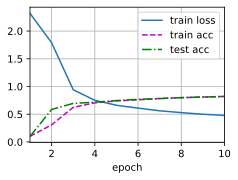

In [7]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Output cell [7]:

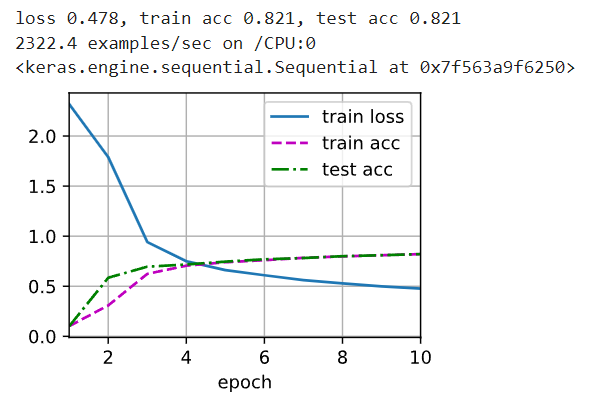

#Summary
* A CNN is a network that employs convolutional layers.

* In a CNN, we interleave convolutions, nonlinearities, and (often) pooling operations.

* In a CNN, convolutional layers are typically arranged so that they gradually decrease the spatial resolution of the representations, while increasing the number of channels.

* In traditional CNNs, the representations encoded by the convolutional blocks are processed by one or more fully-connected layers prior to emitting output.

* LeNet was arguably the first successful deployment of such a network.